In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gensim.corpora import Dictionary

import json #storing files

In [8]:
politics_data = pd.read_csv("../sample_data/politics_sample3.csv", 
                            header=None, 
                            names = ['author', 'subreddit', 'body', 'score', 'created_dt', 'link_id', 'parent_id'],
                            index_col = False)

In [12]:
datetime.fromisoformat(politics_data['created_dt'][0][:10])

datetime.datetime(2016, 2, 24, 0, 0)

In [22]:
politics_text = politics_data.loc[politics_data['body'].notna()]['body'].values

In [14]:
politics_dates = politics_data.loc[politics_data['body'].notna()]['created_dt'].values

In [16]:
politics_date_objs = [datetime.fromisoformat(i[:10]) for i in politics_dates]

In [29]:
datetime(2015, 2, 1) < datetime(2015, 3, 1)

True

In [23]:
print(len(politics_text))
print(len(politics_date_objs))

999960
999960


In [36]:
print(len([i for i in politics_date_objs if i < datetime(2015, 2, 1)]))
print(len([i for i in politics_date_objs if i < datetime(2015, 3, 1)]))
print(len([i for i in politics_date_objs if i >= datetime(2016, 5, 1)]))
print(len([i for i in politics_date_objs if i >= datetime(2016, 4, 1)]))
print(len([i for i in politics_date_objs if i < datetime(2016, 6, 1)]))

20753
39586
122760
247798
999960


In [39]:
months = [datetime(2015, i, 1) for i in range(1,13)] + [datetime(2016, i, 1) for i in range(1,7)]

In [41]:
month_indices = []

for i in range(len(months) - 1):
    month_indices.append([j for j in range(len(politics_date_objs)) 
                         if politics_date_objs[j] >= months[i]  
                         and politics_date_objs[j] < months[i+1]])

<BarContainer object of 17 artists>

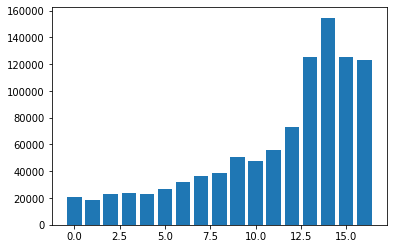

In [45]:
plt.bar(range(len(months)-1), [len(i) for i in month_indices])

In [46]:
text_by_month = []

for lst in month_indices:
    text_by_month.append([politics_text[i] for i in lst])

In [1]:
def tokenize_data(data):
    print("Number of entries in original dataset: " + str(len(data)))
    data1 = [i for i in data if 'thank you for participating' not in i.lower()]
    print("Number of moderator posts removed from dataset: " + str(len([i for i in data if 'thank you for participating' in i.lower()])))
    data1 = [i for i in data1 if i != '[deleted]' and i != '[removed]']
    print("Number of user-deleted posts removed from dataset: " + str(len([i for i in data if i == '[deleted]'])))
    print("Number of mod/admin-deleted posts removed from dataset: " + str(len([i for i in data if i == '[removed]'])))
    
    print("Number of entries in modified dataset: " + str(len(data1)))
    
    # removing hyperlinks
    print("Number of comments with a hyperlink in modified dataset: " + str(len([i for i in data1 if "http" in i])))
    data1 = [re.sub(r'https?:\/\/[\S]+', ' ', i, flags=re.MULTILINE) for i in data1]
    
    # common escape sequences
    data1 = [re.sub(r'\n', '', i) for i in data1]
    data1 = [re.sub(r'&gt;', '', i) for i in data1]
    
    # convert to lowercase
    data1 = [i.lower() for i in data1]
    
    # keep user and subreddit tags
    print("Number of comments that mention a user in the modified dataset: " + str(len([i for i in data1 if "/u/" in i])))
    print("Number of comments that mention a subreddit in the modified dataset: " + str(len([i for i in data1 if "/r/" in i])))
    data1 = [re.sub(r'/u/', '_user_', i) for i in data1]
    data1 = [re.sub(r'/r/', '_subreddit_', i) for i in data1]
    
    data_tokenized = [re.findall(r'\w+', i.lower()) for i in data1]
    
    # remove numbers
    data_tokenized = [[token for token in doc if not token.isnumeric()] for doc in data_tokenized]
    
    print("Number of total tokens: " + str(sum([len(d) for d in data_tokenized])))
    
    return data_tokenized

In [48]:
tokens_by_month = []

for lst in text_by_month:
    tokens_by_month.append(tokenize_data(lst))
    print()

Number of entries in original dataset: 20753
Number of moderator posts removed from dataset: 159
Number of user-deleted posts removed from dataset: 1149
Number of mod/admin-deleted posts removed from dataset: 0
Number of entries in modified dataset: 19445
Number of comments with a hyperlink in modified dataset: 1132
Number of comments that mention a user in the modified dataset: 37
Number of comments that mention a subreddit in the modified dataset: 141
Number of total tokens: 887728

Number of entries in original dataset: 18833
Number of moderator posts removed from dataset: 155
Number of user-deleted posts removed from dataset: 979
Number of mod/admin-deleted posts removed from dataset: 0
Number of entries in modified dataset: 17699
Number of comments with a hyperlink in modified dataset: 1051
Number of comments that mention a user in the modified dataset: 48
Number of comments that mention a subreddit in the modified dataset: 116
Number of total tokens: 808986

Number of entries in 

Number of comments that mention a user in the modified dataset: 238
Number of comments that mention a subreddit in the modified dataset: 1030
Number of total tokens: 4422436



In [50]:
for i in range(len(tokens_by_month)):
    with open("stored_variables/politics_tokens_month" + str(i) + ".json", 'w') as f:
        json.dump(tokens_by_month[i], f)

## Streaming implementation

In [3]:
def remove_bad_comments(chunk, month_vals):
    chunk_notna = chunk.loc[chunk['body'].notna()]
    comments = chunk_notna['body'].values
    auths = chunk_notna['author'].values
    date_vals = chunk_notna['created_dt'].values
    date_objs = [datetime.fromisoformat(i[:10]) for i in date_vals]
    
    comment_lists = []
    auth_lists = []
    
    for i in range(len(month_vals) - 1):
        time_indices = [j for j in range(len(date_objs)) if date_objs[j] >= month_vals[i]
                        and date_objs[j] < month_vals[i+1]]
        
        good_indices = [j for j in time_indices if comments[j] != '[deleted]' 
                        and comments[j] != '[removed]'
                        and 'thank you for participating' not in comments[j].lower()]
        
        comment_lists.append(list(comments[good_indices]))
        auth_lists.append(list(auths[good_indices]))
        
    return (comment_lists, auth_lists)

In [4]:
def tokenize_comments(data):
    # remove hyperlinks
    data1 = [re.sub(r'https?:\/\/[\S]+', ' ', i, flags=re.MULTILINE) for i in data]
    
    # common escape sequences
    data1 = [re.sub(r'\n', '', i) for i in data1]
    data1 = [re.sub(r'&gt;', '', i) for i in data1]
    
    # convert to lowercase
    data1 = [i.lower() for i in data1]
    
    # keep user and subreddit tags
    data1 = [re.sub(r'/u/', '_user_', i) for i in data1]
    data1 = [re.sub(r'/r/', '_subreddit_', i) for i in data1]
    
    data_tokenized = [re.findall(r'\w+', i.lower()) for i in data1]
    
    # remove numbers
    data_tokenized = [[token for token in doc if not token.isnumeric()] for doc in data_tokenized]
    
    return data_tokenized

In [5]:
comment_auths = [[]] * 24
comment_tokens = [[]] * 24

In [6]:
months2 = [datetime(2015, i, 1) for i in range(1,13)] + [datetime(2016, i, 1) for i in range(1,13)] + \
[datetime(2017, 1, 1)]


In [16]:
# test appending
with open("test_file.json", 'w') as f:
    f.write('[')
    
with open("test_file.json", 'a') as f:
    f.write(json.dumps([1,2,3])[1:-1])
    f.write(',')
    
with open('test_file.json', 'a') as f:
    f.write(json.dumps([4,5,6])[1:-1])
    f.write(']')
    
with open('test_file.json', 'r') as f:
    print(json.load(f))


[1, 2, 3, 4, 5, 6]


In [7]:
for i in range(24):
    with open("stored_variables/politics_tokens2_month" + str(i) + ".json", 'w') as f:
        f.write('[')
        
for i in range(len(comment_auths)):
    with open("stored_variables/politics_auths2_month" + str(i) + ".json", 'w') as f:
        f.write('[')

In [8]:
chunk_size = 5 * (10 ** 5)
iter_num = 0
not_first = [False] * 24

for chunk in pd.read_csv("../sample_data/politics_comments_2015_2016_2.csv", 
                         header=None, 
                         names = ['author', 'subreddit', 'body', 'score', 'created_dt', 'link_id', 'parent_id', 'id'],
                         usecols = ['author','body', 'created_dt'],
                         index_col = False,
                         chunksize = chunk_size
                         ):
    iter_num += 1
    comments, auths = remove_bad_comments(chunk, months2)
    
    for i in range(len(months2) - 1):
        if len(auths[i]) > 0:
            comment_toks = tokenize_comments(comments[i])

            with open("stored_variables/politics_tokens2_month" + str(i) + ".json", 'a') as f:
                if not_first[i]:
                    f.write(',')
                f.write(json.dumps(comment_toks)[1:-1])

            with open("stored_variables/politics_auths2_month" + str(i) + ".json", 'a') as f:
                if not_first[i]:
                    f.write(',')
                f.write(json.dumps(auths[i])[1:-1])

            not_first[i] = True
    
    print(iter_num * chunk_size)

500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
8500000
9000000
9500000
10000000
10500000
11000000
11500000
12000000
12500000
13000000
13500000
14000000
14500000
15000000
15500000
16000000
16500000
17000000
17500000
18000000
18500000
19000000
19500000
20000000
20500000
21000000
21500000
22000000
22500000
23000000
23500000


In [9]:
for i in range(24):
    with open("stored_variables/politics_tokens2_month" + str(i) + ".json", 'a') as f:
        f.write(']')
        
for i in range(len(comment_auths)):
    with open("stored_variables/politics_auths2_month" + str(i) + ".json", 'a') as f:
        f.write(']')